In [1]:
from featureExtractor import *
subjects = [i for i in range (0, 27)]
exclude_subs = [5, 16, 19, 22, 24, 26]

subjects = [s for s in subjects if s not in exclude_subs]

In [2]:
lie_features = pd.read_csv("lie_features_clear_whole_35.csv", sep=',')
lie_features['descr_mean_pupil'] = (lie_features['descr_right_mean'] + lie_features['descr_left_mean'])/2
lie_features['react_mean_pupil'] = (lie_features['react_right_mean'] + lie_features['react_left_mean'])/2
lie_features['point_mean_pupil'] = (lie_features['point_right_mean'] + lie_features['point_left_mean'])/2
lie_feat_cols.append('descr_mean_pupil')
lie_feat_cols.append('react_mean_pupil')
lie_feat_cols.append('point_mean_pupil')

In [3]:
quest_ans = preprocessQuest("data/personality_raw.csv")
quest_ans = quest_ans.loc[quest_ans['subject'].isin(subjects)]
quest_ans = quest_ans.sort_values(by=['subject'])
quest_ans = quest_ans.reset_index()
quest_ans['subject'] = quest_ans.index

In [4]:
goods = []

for sc in ["premed_index", 'descr_ratio', 'react_ratio']:
    for q in quest_ans.columns:
        qa = quest_ans[[q]]
        intersect, slope, adj, p = linear_regression_quest_scores(tnt_scores, qa, score=sc)
        if(p < 0.05):
            goods.append([q, sc, slope[1], adj, p])
            #goods.append((intersect, slope, q, sc, adj, p))
            #print("{} {} {} {}".format(q, sc, adj, p))

reg_df = pd.DataFrame(columns=['quest_feat', 'feature', 'slope', 'asjust', 'p'], data=goods)
            
#for (intersect, slope, q, sc, adj, p) in goods:
#    print("{} {} {} {} {}".format(q, sc, slope[1], adj, p))
    
reg_df

NameError: name 'tnt_scores' is not defined

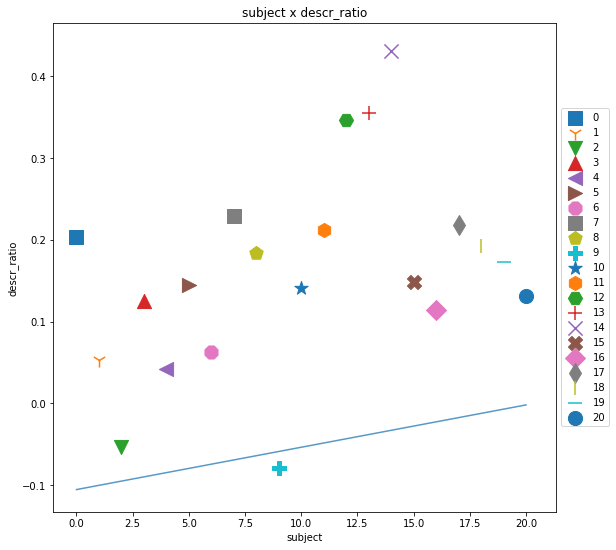

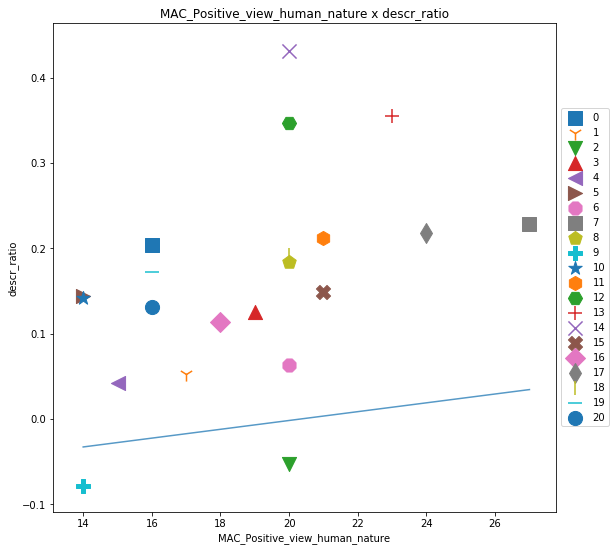

In [25]:
qa = quest_ans[['subject', 'MAC_Positive_view_human_nature']]
intersect, slope, adj, p = linear_regression_quest_scores(tnt_scores, qa, score="descr_ratio")
lie_plotQuestRegression(lie_features, qa, slope[1], intersect, index_col="descr_ratio")

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


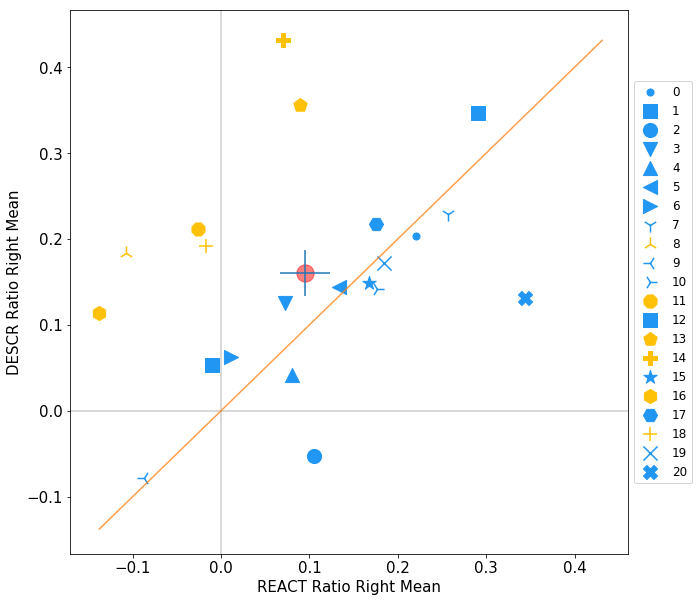

In [52]:

def TNT_points(feature, title, abs_ratio=False, norm_to_point=False, save_root="", save=False):
    
    marker_map = {
    8 : ( "2", "#FFC107" ),
    11 : ( "8", "#FFC107" ),
    13 : ( "p", "#FFC107" ), 
    14 : ( "P", "#FFC107" ), 
    16 : ( "h", "#FFC107" ),
    18 : ( "+", "#FFC107" ),
    
    0 : ( ".", "#2196F3" ), 
    1 : ( ",", "#2196F3" ), 
    2 : ( "o", "#2196F3" ), 
    3 : ( "v", "#2196F3" ), 
    4 : ( "^", "#2196F3" ), 
    5 : ( "<", "#2196F3" ), 
    6 : ( ">", "#2196F3" ), 
    7 : ( "1", "#2196F3" ),     
    9 : ( "3", "#2196F3" ),
    10 : ( "4", "#2196F3" ),     
    12 : ( "s", "#2196F3" ),    
    15 : ( "*", "#2196F3" ),
    17 : ( "H", "#2196F3" ), 
    19 : ( "x", "#2196F3" ), 
    20 : ( "X", "#2196F3" ), 
    21 : ( "D", "#2196F3" ), 
    22 : ( "d", "#2196F3" ), 
    23 : ( "|", "#2196F3" ), 
    24 : ( "_", "#2196F3" ), 
    }
    
    tnt_scores, sss = coumpute_TnT_scores(lie_features, lie_feat_cols, feature, abs_ratio=abs_ratio, norm_to_point=norm_to_point)
    
    print(sss)
    
    f, axs = plt.subplots(1, figsize=(10, 10), num="{}".format(feature))
    pallX = tnt_scores['react_ratio'].mean(skipna=True)
    pallX_ste = tnt_scores['react_ratio'].sem(skipna=True)    
    pallY = tnt_scores['descr_ratio'].mean(skipna=True)
    pallY_ste = tnt_scores['descr_ratio'].sem(skipna=True)

    labels = []
    size = 200
    label_font_size = 15
    legend_prop_size = {'size': 12}

    for i, sub in enumerate(sss):

        marker = marker_map[sub][0]

        axs.set_xlabel("REACT Ratio {}".format(title), fontsize=label_font_size)
        axs.set_ylabel("DESCR Ratio {}".format(title), fontsize=label_font_size)
        axs.set_label("{}".format(sub))
        
        color = marker_map[sub][1]
        labels.append("{}".format(sub))
        marker = marker_map[sub][0]
        
        axs.scatter(tnt_scores.loc[tnt_scores['subject'] == sub]['react_ratio'],
                            tnt_scores.loc[tnt_scores['subject'] == sub]['descr_ratio'],
                            s=size,
                            c=color,
                            marker=marker)

    minX = tnt_scores['react_ratio'].min()
    maxX = tnt_scores['react_ratio'].max()        
    minY = tnt_scores['descr_ratio'].min()
    maxY = tnt_scores['descr_ratio'].max()       
    minXY = min(minX, minY)
    maxXY = max(maxX, maxY)

    mn = (maxXY + minXY) / 20

    #minXY = minXY - mn
    #maxXY = maxXY + mn
    
    lims = [minXY, maxXY]
    
    plt.legend(labels, loc='center left', bbox_to_anchor=(1, 0.5), prop=legend_prop_size)  
    axs.scatter(pallX, pallY, s=300, alpha=0.5, color='red')
    axs.errorbar(pallX, pallY,
                xerr=pallX_ste,
                yerr=pallY_ste,)
    
    axs.plot(lims, lims, alpha=0.75, zorder=100)
    axs.axvline(color='black', alpha=0.2)
    axs.axhline(color='black', alpha=0.2)
    axs.tick_params(axis='both', which='major', labelsize=label_font_size)
    
    if(save):
        f.savefig(save_root.format(feature), dpi=3000)
    

TNT_points('right_mean', "Right Mean", norm_to_point=False, abs_ratio=False, save=True, save_root="V2_clear_35/plot/hd/tnt_{}.svg")


In [29]:
lie_features.columns

Index(['subject', 'source', 'card_class', 'show_order', 'duration',
       'react_dur', 'point_dur', 'descr_dur', 'fix_freq', 'sacc_freq',
       'right_mean', 'right_std', 'right_min', 'right_max', 'left_mean',
       'left_std', 'left_min', 'left_max', 'react_fix_freq', 'react_sacc_freq',
       'react_right_mean', 'react_right_std', 'react_right_min',
       'react_right_max', 'react_left_mean', 'react_left_std',
       'react_left_min', 'react_left_max', 'point_fix_freq', 'point_sacc_freq',
       'point_right_mean', 'point_right_std', 'point_right_min',
       'point_right_max', 'point_left_mean', 'point_left_std',
       'point_left_min', 'point_left_max', 'descr_fix_freq', 'descr_sacc_freq',
       'descr_right_mean', 'descr_right_std', 'descr_right_min',
       'descr_right_max', 'descr_left_mean', 'descr_left_std',
       'descr_left_min', 'descr_left_max', 'label', 'descr_mean_pupil',
       'react_mean_pupil', 'point_mean_pupil'],
      dtype='object')